In [ ]:
import pandas as pd
import numpy as np
import torch
import random
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torch import nn

# Function to generate synthetic examples using examples from the dataset
def generate_synthetic_examples(df, category, num_examples=10, domain="female soccer"):
    """
    Generate synthetic examples for a specific category based on existing examples.
    
    Args:
        df: DataFrame with the original data
        category: Category to generate examples for
        num_examples: Number of examples to generate
        domain: Domain to focus on (e.g., "female soccer")
        
    Returns:
        List of synthetic examples
    """
    # Get existing examples for this category to use as seeds
    existing_examples = df[df[category] == 1]['comment'].tolist()
    
    # If no existing examples or very few, use some generic patterns
    if len(existing_examples) < 3:
        if category == 'sexism':
            patterns = [
                f"Women's {domain} is not real {domain}, they should stick to [activity].",
                f"Female {domain} players are only popular because of their looks, not skill.",
                f"Women are too [negative trait] to play {domain} at a high level.",
                f"The problem with women's {domain} is that women are naturally worse at sports.",
                f"No one watches women's {domain} because they're not as good as men.",
                f"This female {domain} player only got attention because she's pretty.",
                f"Women's {domain} is boring because they're slower and weaker.",
                f"They should reduce the {domain} field size for women since they can't cover as much ground.",
                f"Women {domain} players earn less because they generate less revenue, it's simple economics.",
                f"The women's {domain} team is just asking for special treatment."
            ]
        elif category == 'racism':
            patterns = [
                f"Players from [nationality/ethnicity] aren't technically skilled enough for {domain}.",
                f"That [ethnicity] player only got on the team because of diversity quotas.",
                f"{domain} was better before they let so many [ethnicity] players in.",
                f"Teams from [region/country] always play dirty because it's in their culture.",
                f"You can tell that player is [ethnicity] by how [negative stereotype] they play.",
                f"[Nationality] players always dive more in {domain}, it's part of their culture.",
                f"{domain} fans from [country] are naturally more violent, it's genetic.",
                f"The [ethnicity] players on that {domain} team all look the same.",
                f"[Country] doesn't produce good {domain} players because they're not built for it.",
                f"That referee is clearly biased against [ethnicity] players."
            ]
        elif category == 'violence':
            patterns = [
                f"That referee deserves to be beaten for that call in the {domain} match.",
                f"Someone should attack that {domain} player for missing that shot.",
                f"I'd like to hurt the coach for making that substitution in the {domain} game.",
                f"Fans should physically confront that {domain} player after the match.",
                f"That {domain} team should be assaulted for such a poor performance.",
                f"I hope someone breaks that player's legs in the next {domain} match.",
                f"The only solution is to punch that {domain} commentator in the face.",
                f"I would smash my TV if I had to watch another women's {domain} match.",
                f"That {domain} player deserves to get hit hard in the next game.",
                f"Fans should throw objects at that {domain} team for playing so badly."
            ]
        elif category == 'appearance':
            patterns = [
                f"That female {domain} player is too ugly to be on camera.",
                f"She should focus more on losing weight than playing {domain}.",
                f"No wonder she's bad at {domain}, look at how fat she is.",
                f"That {domain} player would be more popular if she was prettier.",
                f"Who cares about her {domain} skills when she looks like that?",
                f"Her thighs are too big for a {domain} player, it's distracting.",
                f"That female {domain} player's hairstyle is ridiculous, focus on the game.",
                f"She's too skinny to be taken seriously as a {domain} player.",
                f"The uniforms make these female {domain} players look so unflattering.",
                f"I can't focus on her {domain} skills because her face is so distracting."
            ]
        elif category == 'ability':
            patterns = [
                f"You must be mentally disabled if you think women's {domain} is worth watching.",
                f"Only someone with brain damage would coach women's {domain}.",
                f"That {domain} player looks like she has some kind of disability.",
                f"Are you blind? That's why you support women's {domain}.",
                f"You must have a learning disability to not understand why men's {domain} is superior.",
                f"What are you, retarded? This {domain} team is clearly better.",
                f"That player moves like she's got a physical disability on the {domain} field.",
                f"You'd need to be deaf to not hear how the crowd hates this {domain} team.",
                f"The coach must be mentally challenged to make such poor {domain} decisions.",
                f"Only people with cognitive issues would find women's {domain} entertaining."
            ]
        else:  # non-offensive
            patterns = [
                f"I really enjoyed watching the women's {domain} match yesterday.",
                f"The technical skill in women's {domain} has improved so much.",
                f"That was an amazing goal in the {domain} championship.",
                f"The tactical approach of this women's {domain} team is impressive.",
                f"Female {domain} players are showing great progress in recent years.",
                f"The women's {domain} world cup was really exciting to watch.",
                f"I admire the dedication of these {domain} players.",
                f"The defensive strategy in this women's {domain} match is fascinating.",
                f"Both teams played exceptionally well in this {domain} match.",
                f"The level of athleticism in women's {domain} keeps getting better every year."
            ]
    else:
        # Use existing examples as patterns
        patterns = existing_examples
    
    # Generate variations based on patterns
    synthetic_examples = []
    
    for _ in range(num_examples):
        # Choose a random pattern to base this example on
        base_pattern = random.choice(patterns)
        
        # Create variations based on the domain and category
        if category == 'sexism':
            replacements = {
                '[activity]': random.choice(['cooking', 'cleaning', 'modeling', 'cheerleading', 'dancing', 'fashion']),
                '[negative trait]': random.choice(['emotional', 'weak', 'fragile', 'sensitive', 'indecisive', 'dramatic'])
            }
        elif category == 'racism':
            replacements = {
                '[nationality/ethnicity]': random.choice(['African', 'Asian', 'Latin American', 'Eastern European', 'Middle Eastern']),
                '[ethnicity]': random.choice(['Black', 'Asian', 'Latino', 'African', 'Arab']),
                '[region/country]': random.choice(['African countries', 'South American teams', 'Eastern European nations', 'Asian teams']),
                '[negative stereotype]': random.choice(['aggressively', 'sloppily', 'lazily', 'dishonestly', 'chaotically'])
            }
        elif category == 'appearance':
            # No specific replacements needed
            replacements = {}
        elif category == 'ability':
            # No specific replacements needed
            replacements = {}
        elif category == 'violence':
            # No specific replacements needed
            replacements = {}
        else:  # non-offensive
            replacements = {}
        
        # Apply replacements
        new_example = base_pattern
        for key, value in replacements.items():
            if key in new_example:
                new_example = new_example.replace(key, value)
        
        # Add some noise/variation
        if random.random() < 0.3:
            new_example = new_example.replace(".", "!")
        
        if random.random() < 0.4:
            intensifiers = ["so", "really", "extremely", "very", "absolutely", "totally"]
            words = new_example.split()
            for i in range(len(words) - 1):
                if random.random() < 0.1:
                    words.insert(i+1, random.choice(intensifiers))
            new_example = " ".join(words)
        
        # Add to our collection if it's not a duplicate
        if new_example not in synthetic_examples:
            synthetic_examples.append(new_example)
    
    return synthetic_examples

# Function to enhance dataset with synthetic examples
def enhance_dataset_with_synthetic_examples(df, categories, examples_per_category=200, domain="female soccer", skip_categories=None):
    """
    Enhance the dataset with synthetically generated examples.
    
    Args:
        df: Original DataFrame
        categories: List of categories to generate examples for
        examples_per_category: Number of examples to generate per category
        domain: Domain to focus on
        skip_categories: List of categories to skip enhancement for
    
    Returns:
        Enhanced DataFrame
    """
    # Default to empty list if None
    if skip_categories is None:
        skip_categories = []
    
    # Create a copy to avoid modifying the original
    enhanced_df = df.copy()
    
    # Generate synthetic examples for each underrepresented category
    for category in categories:
        # Skip categories in the skip list
        if category in skip_categories:
            print(f"Skipping enhancement for {category} as requested")
            continue
        
        # Calculate current count
        current_count = df[category].sum()
        print(f"Original {category} examples: {current_count}")
        
        # Generate synthetic examples
        synthetic_examples = generate_synthetic_examples(
            df, 
            category, 
            num_examples=examples_per_category,
            domain=domain
        )
        
        # Create new rows for the DataFrame
        new_rows = []
        for example in synthetic_examples:
            # Initialize with all categories set to 0
            new_row = {cat: 0 for cat in categories}
            # Set this category to 1
            new_row[category] = 1
            # Add the comment text
            new_row['comment'] = example
            # Set as labeled
            if 'is_labeled' in df.columns:
                new_row['is_labeled'] = True
                
            new_rows.append(new_row)
        
        # Convert to DataFrame
        synthetic_df = pd.DataFrame(new_rows)
        
        # Append to the enhanced DataFrame
        enhanced_df = pd.concat([enhanced_df, synthetic_df], ignore_index=True)
        
        # Calculate new count
        new_count = enhanced_df[category].sum()
        print(f"After enhancement, {category} examples: {new_count} (+{new_count-current_count})")
    
    return enhanced_df

# Function to convert pandas DataFrame to HuggingFace Dataset
def convert_to_hf_dataset(df, tokenizer, categories, max_length=128):
    """Convert pandas DataFrame to HuggingFace Dataset."""
    # Extract features and labels
    comments = df['comment'].tolist()
    labels = df[categories].values.astype(np.float32)
    
    # Tokenize the comments
    encodings = tokenizer(
        comments,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='np'
    )
    
    # Create a dataset dictionary
    dataset_dict = {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    }
    
    # Convert to HF Dataset
    dataset = HFDataset.from_dict(dataset_dict)
    return dataset

# MODIFIED: Enhanced compute_metrics with lower thresholds for minority classes
def compute_metrics(eval_pred):
    """Compute metrics for multi-label classification with focus on macro F1."""
    predictions, labels = eval_pred
    # Apply sigmoid to get probabilities
    sigmoid_preds = 1 / (1 + np.exp(-predictions))
    
    # Use different thresholds for different classes to improve minority class detection
    y_pred = np.zeros_like(sigmoid_preds, dtype=int)
    
    # Use a higher threshold for majority class
    y_pred[:, -1] = (sigmoid_preds[:, -1] >= 0.7).astype(int)  # non-offensive uses 0.7 (stricter)
    
    # Use MUCH lower thresholds for minority classes to increase recall
    for i in range(len(y_pred[0])-1):  # All except the last column (non-offensive)
        y_pred[:, i] = (sigmoid_preds[:, i] >= 0.2).astype(int)  # Use 0.2 for minority classes
    
    # Calculate metrics
    metrics = {}
    metrics['micro_f1'] = f1_score(labels, y_pred, average='micro')
    metrics['macro_f1'] = f1_score(labels, y_pred, average='macro')
    
    # Per-category metrics
    categories = ["sexism", "racism", "violence", "appearance", "ability", "non-offensive"]
    for i, category in enumerate(categories):
        if np.sum(labels[:, i]) > 0:  # Only if at least one positive example exists
            metrics[f'{category}_f1'] = f1_score(labels[:, i], y_pred[:, i], average='binary')
            metrics[f'{category}_precision'] = precision_score(labels[:, i], y_pred[:, i], average='binary', zero_division=0)
            metrics[f'{category}_recall'] = recall_score(labels[:, i], y_pred[:, i], average='binary', zero_division=0)
    
    return metrics

# Prediction function with proper tensor handling
def get_predictions(dataset, model, device, batch_size=16, threshold=0.5, category_thresholds=None):
    """
    Generate predictions for the dataset.
    
    Args:
        dataset: HuggingFace dataset
        model: Trained model
        device: Device to use
        batch_size: Batch size
        threshold: Default threshold for classification
        category_thresholds: Dictionary mapping category indices to thresholds
    """
    if category_thresholds is None:
        # Use the same thresholds as in compute_metrics
        category_thresholds = {
            0: 0.2,  # sexism
            1: 0.2,  # racism
            2: 0.2,  # violence
            3: 0.2,  # appearance
            4: 0.2,  # ability
            5: 0.7   # non-offensive
        }
    
    model.eval()
    all_preds = []
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        collate_fn=lambda batch: {
            'input_ids': torch.tensor([item['input_ids'] for item in batch]),
            'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
            'labels': torch.tensor([item['labels'] for item in batch])
        }
    )
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        all_preds.append(probs)
    
    # Return probabilities
    return np.vstack(all_preds)

# NEW function: Create CustomTrainer with weighted loss
class WeightedBCEWithLogitsLoss(nn.Module):
    """
    Binary Cross Entropy with logits loss that applies class weights.
    Useful for handling class imbalance.
    """
    def __init__(self, pos_weights, reduction='mean'):
        super().__init__()
        self.pos_weights = pos_weights
        self.reduction = reduction

    def forward(self, logits, targets):
        # Apply sigmoid for numerical stability
        probs = torch.sigmoid(logits)
        # Calculate loss with pos_weight for each class
        loss = torch.zeros_like(logits)
        
        # Apply weight for each class
        for i in range(logits.size(1)):
            # Extract this class
            class_logits = logits[:, i]
            class_targets = targets[:, i]
            
            # Apply BCEWithLogitsLoss for this class with its weight
            loss[:, i] = nn.functional.binary_cross_entropy_with_logits(
                class_logits, 
                class_targets, 
                pos_weight=torch.tensor([self.pos_weights[i]]).to(logits.device),
                reduction='none'
            )
        
        # Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

class CustomTrainer(Trainer):
    """Custom trainer with weighted loss to handle class imbalance."""
    def __init__(self, pos_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights or [1.0] * self.model.config.num_labels
        
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply weighted loss
        loss_fct = WeightedBCEWithLogitsLoss(pos_weights=self.pos_weights)
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

# Function to ensure category examples in test set
def ensure_category_examples_in_test(df, test_df, categories, min_examples=5, domain="female soccer"):
    """
    Ensures that test set has at least min_examples of each category.
    
    Args:
        df: Original full DataFrame
        test_df: Test DataFrame that might be missing category examples
        categories: List of categories to check
        min_examples: Minimum number of examples per category
        domain: Domain for synthetic examples
        
    Returns:
        Updated test DataFrame with examples for each category
    """
    # Create a copy of the test DataFrame
    enhanced_test_df = test_df.copy()
    
    # Check each category
    for category in categories:
        # Get current count in test set
        current_count = test_df[category].sum()
        print(f"Test set {category} examples: {current_count}")
        
        # If we don't have enough examples, add synthetic ones
        if current_count < min_examples:
            needed = min_examples - current_count
            print(f"Need {needed} more {category} examples in test set")
            
            # Generate synthetic examples
            synthetic_examples = generate_synthetic_examples(
                df,  # Use the full dataset as source
                category,
                num_examples=needed,
                domain=domain
            )
            
            # Create new rows for the DataFrame
            new_rows = []
            for example in synthetic_examples:
                # Initialize with all categories set to 0
                new_row = {cat: 0 for cat in categories}
                # Set this category to 1
                new_row[category] = 1
                # Add the comment text
                new_row['comment'] = example
                # Set as labeled
                if 'is_labeled' in df.columns:
                    new_row['is_labeled'] = True
                    
                new_rows.append(new_row)
            
            # Convert to DataFrame
            synthetic_df = pd.DataFrame(new_rows)
            
            # Append to the enhanced test DataFrame
            enhanced_test_df = pd.concat([enhanced_test_df, synthetic_df], ignore_index=True)
            
            # Print the new count
            new_count = enhanced_test_df[category].sum()
            print(f"After enhancement, test set {category} examples: {new_count}")
    
    return enhanced_test_df

# MODIFIED: Custom stratified split with more test examples
def stratified_multi_label_split(df, categories, test_size=0.2, min_test_examples=10, random_state=42):
    """
    Custom stratified split for multi-label data ensuring minimum examples per category.
    
    Args:
        df: DataFrame to split
        categories: List of category columns
        test_size: Fraction of data to use for test
        min_test_examples: Minimum number of examples per category in test set
        random_state: Random seed
        
    Returns:
        train_df, test_df: Split DataFrames
    """
    # Initialize empty test set
    test_indices = set()
    train_indices = set(range(len(df)))
    
    # For each category, ensure we have min_test_examples
    for category in categories:
        # Get indices where this category is 1
        category_indices = df[df[category] == 1].index.tolist()
        
        # If we have enough examples
        if len(category_indices) >= min_test_examples:
            # Shuffle the indices
            random.Random(random_state).shuffle(category_indices)
            # Take the first min_test_examples
            examples_to_add = set(category_indices[:min_test_examples])
            # Add to test indices
            test_indices.update(examples_to_add)
        else:
            # If not enough examples, take what we have
            test_indices.update(category_indices)
            print(f"Warning: Only {len(category_indices)} examples of {category} available")
    
    # Calculate how many more test examples we need for the desired test_size
    desired_test_size = int(len(df) * test_size)
    additional_needed = max(0, desired_test_size - len(test_indices))
    
    if additional_needed > 0:
        # Get remaining indices not yet in test set
        remaining_indices = list(train_indices - test_indices)
        # Shuffle them
        random.Random(random_state).shuffle(remaining_indices)
        # Take what we need
        additional_indices = set(remaining_indices[:additional_needed])
        # Add to test indices
        test_indices.update(additional_indices)
    
    # Create the train indices by removing test indices from all indices
    train_indices = set(range(len(df))) - test_indices
    
    # Convert to list for indexing
    train_indices = list(train_indices)
    test_indices = list(test_indices)
    
    # Create DataFrames
    train_df = df.iloc[train_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)
    
    return train_df, test_df

# NEW FUNCTION: Create balanced batches during training
def create_balanced_sampler(dataset, categories):
    """
    Creates a sampler that ensures each batch has examples from all categories.
    Helps prevent the model from getting stuck in local minima.
    
    Args:
        dataset: Dataset to sample from
        categories: Category names
    
    Returns:
        Sampler for DataLoader
    """
    pass  # Not implemented here as we're using HuggingFace Trainer API

# IMPROVED: Main function with better balancing for macro F1
def train_model_with_synthetic_data(data_path, domain="female soccer"):
    """
    Complete pipeline to train model with synthetic data enhancement,
    optimized for maximizing macro F1 score.
    
    Args:
        data_path: Path to the original labeled data
        domain: Domain to focus synthetic examples on
    """
    # Configuration
    CONFIG = {
        "test_size": 0.2,
        "model_name": "distilbert-base-uncased",
        "output_dir": "./finetuned_model",
        "max_length": 128,
        "batch_size": 16,
        "learning_rate": 2e-5,  # Slightly lower learning rate for better generalization
        "epochs": 15,  # More epochs to ensure convergence
        "seed": 42,
        "categories": ["sexism", "racism", "violence", "appearance", "ability", "non-offensive"],
        "min_test_examples": 10,  # Increased minimum examples per category in test set
        # Thresholds for evaluation
        "thresholds": {
            "sexism": 0.2,
            "racism": 0.2,
            "violence": 0.2,
            "appearance": 0.2,
            "ability": 0.2,
            "non-offensive": 0.7
        },
        # Class weights to combat imbalance (higher values for minority classes)
        "class_weights": [10.0, 10.0, 8.0, 10.0, 8.0, 1.0]  # Higher weights for minority classes
    }
    
    # Set seeds
    torch.manual_seed(CONFIG["seed"])
    np.random.seed(CONFIG["seed"])
    random.seed(CONFIG["seed"])
    
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    print(f"Loading data from {data_path}")
    df = pd.read_csv(data_path)
    
    # Filter labeled data
    if 'is_labeled' in df.columns:
        df = df[df['is_labeled'] == True].reset_index(drop=True)
        print(f"Found {len(df)} labeled comments")
    
    # Use custom stratified split with more examples per category
    train_df, test_df = stratified_multi_label_split(
        df, 
        CONFIG["categories"], 
        test_size=CONFIG["test_size"],
        min_test_examples=CONFIG["min_test_examples"],
        random_state=CONFIG["seed"]
    )
    
    # Ensure test set has examples from each category
    test_df = ensure_category_examples_in_test(
        df,
        test_df,
        CONFIG["categories"],
        min_examples=CONFIG["min_test_examples"],
        domain=domain
    )
    
    # MODIFIED: Stronger enhancement of minority classes
    # Generate more examples for rare categories
    examples_per_category = {
        "sexism": 800,       # More examples for rarer classes
        "racism": 800,
        "violence": 600,
        "appearance": 800,
        "ability": 600,
        "non-offensive": 0   # None for majority class
    }
    
    # Enhanced training data with more synthetic examples for minority classes
    enhanced_train_df = train_df.copy()
    
    # Enhance each category separately with its optimal count
    for category, num_examples in examples_per_category.items():
        if num_examples > 0:
            current_count = enhanced_train_df[category].sum()
            print(f"Enhancing {category} examples from {current_count}...")
            
            # Generate synthetic examples
            synthetic_examples = generate_synthetic_examples(
                df,  # Use full dataset as source
                category,
                num_examples=num_examples,
                domain=domain
            )
            
            # Create new rows
            new_rows = []
            for example in synthetic_examples:
                # Initialize with all categories set to 0
                new_row = {cat: 0 for cat in CONFIG["categories"]}
                # Set this category to 1
                new_row[category] = 1
                # Add the comment text
                new_row['comment'] = example
                # Set as labeled
                if 'is_labeled' in df.columns:
                    new_row['is_labeled'] = True
                    
                new_rows.append(new_row)
            
            # Convert to DataFrame
            synthetic_df = pd.DataFrame(new_rows)
            
            # Append to the enhanced train DataFrame
            enhanced_train_df = pd.concat([enhanced_train_df, synthetic_df], ignore_index=True)
            
            # Print the new count
            new_count = enhanced_train_df[category].sum()
            print(f"After enhancement, {category} examples: {new_count} (+{new_count-current_count})")
    
    # Downsample non-offensive in training set to reduce imbalance
    non_offensive_count = enhanced_train_df["non-offensive"].sum()
    non_offensive_indices = enhanced_train_df[enhanced_train_df["non-offensive"] == 1].index.tolist()
    
    # Target a more balanced ratio
    target_non_offensive = int(enhanced_train_df.shape[0] * 0.4)  # Aim for 40% non-offensive
    if non_offensive_count > target_non_offensive:
        # Shuffle indices
        random.shuffle(non_offensive_indices)
        # Select indices to remove
        indices_to_remove = non_offensive_indices[:int(non_offensive_count - target_non_offensive)]
        # Drop rows
        enhanced_train_df = enhanced_train_df.drop(indices_to_remove).reset_index(drop=True)
        print(f"Downsampled non-offensive examples from {non_offensive_count} to {enhanced_train_df['non-offensive'].sum()}")
    
    # Print dataset statistics
    print(f"\nOriginal training set size: {len(train_df)}")
    print(f"Enhanced training set size: {len(enhanced_train_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Calculate and print class distribution in enhanced dataset
    print("\nClass distribution in enhanced training set:")
    for category in CONFIG["categories"]:
        count = enhanced_train_df[category].sum()
        print(f"{category}: {count} ({count/len(enhanced_train_df):.2%})")
    
    # Print class distribution in test set
    print("\nClass distribution in test set:")
    for category in CONFIG["categories"]:
        count = test_df[category].sum()
        print(f"{category}: {count} ({count/len(test_df):.2%})")
    
    # Load model and tokenizer
    print(f"\nLoading model: {CONFIG['model_name']}")
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
    model = AutoModelForSequenceClassification.from_pretrained(
        CONFIG["model_name"],
        num_labels=len(CONFIG["categories"]),
        problem_type="multi_label_classification"
    )
    model.to(device)
    
    # Convert to datasets
    train_dataset = convert_to_hf_dataset(enhanced_train_df, tokenizer, CONFIG["categories"], CONFIG["max_length"])
    test_dataset = convert_to_hf_dataset(test_df, tokenizer, CONFIG["categories"], CONFIG["max_length"])

Using device: cpu
Loading data from labeled_data.csv
Found 588 labeled comments
Test set sexism examples: 10
Test set racism examples: 5
Need 5 more racism examples in test set
After enhancement, test set racism examples: 9
Test set violence examples: 14
Test set appearance examples: 5
Need 5 more appearance examples in test set
After enhancement, test set appearance examples: 9
Test set ability examples: 12
Test set non-offensive examples: 83
Enhancing sexism examples from 0...
After enhancement, sexism examples: 197 (+197)
Enhancing racism examples from 0...
After enhancement, racism examples: 204 (+204)
Enhancing violence examples from 8...
After enhancement, violence examples: 240 (+232)
Enhancing appearance examples from 0...
After enhancement, appearance examples: 226 (+226)
Enhancing ability examples from 5...
After enhancement, ability examples: 200 (+195)

Original training set size: 471
Enhanced training set size: 1525
Test set size: 125

Class distribution in enhanced traini

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomTrainer failed with error: Boolean value of Tensor with more than one value is ambiguous
Falling back to standard Trainer with compute_metrics
Starting training...


Step,Training Loss
10,0.631000
20,0.508200
30,0.450600
40,0.421300
50,0.406400
60,0.374000
70,0.352000
80,0.315900
90,0.288900
100,0.272900



Evaluation results:
eval_loss: 0.0837
eval_micro_f1: 0.9520
eval_macro_f1: 0.9327
eval_sexism_f1: 0.9000
eval_sexism_precision: 0.9000
eval_sexism_recall: 0.9000
eval_racism_f1: 1.0000
eval_racism_precision: 1.0000
eval_racism_recall: 1.0000
eval_violence_f1: 0.8571
eval_violence_precision: 0.8571
eval_violence_recall: 0.8571
eval_appearance_f1: 0.9474
eval_appearance_precision: 0.9000
eval_appearance_recall: 1.0000
eval_ability_f1: 0.9167
eval_ability_precision: 0.9167
eval_ability_recall: 0.9167
eval_non-offensive_f1: 0.9753
eval_non-offensive_precision: 1.0000
eval_non-offensive_recall: 0.9518
eval_runtime: 11.3009
eval_samples_per_second: 11.0610
eval_steps_per_second: 0.7080
epoch: 15.0000

Detailed test metrics with optimized thresholds:
sexism:
  Precision: 0.9000
  Recall: 0.9000
  F1 Score: 0.9000
racism:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
violence:
  Precision: 0.8571
  Recall: 0.8571
  F1 Score: 0.8571
appearance:
  Precision: 0.9000
  Recall: 1.0000
  

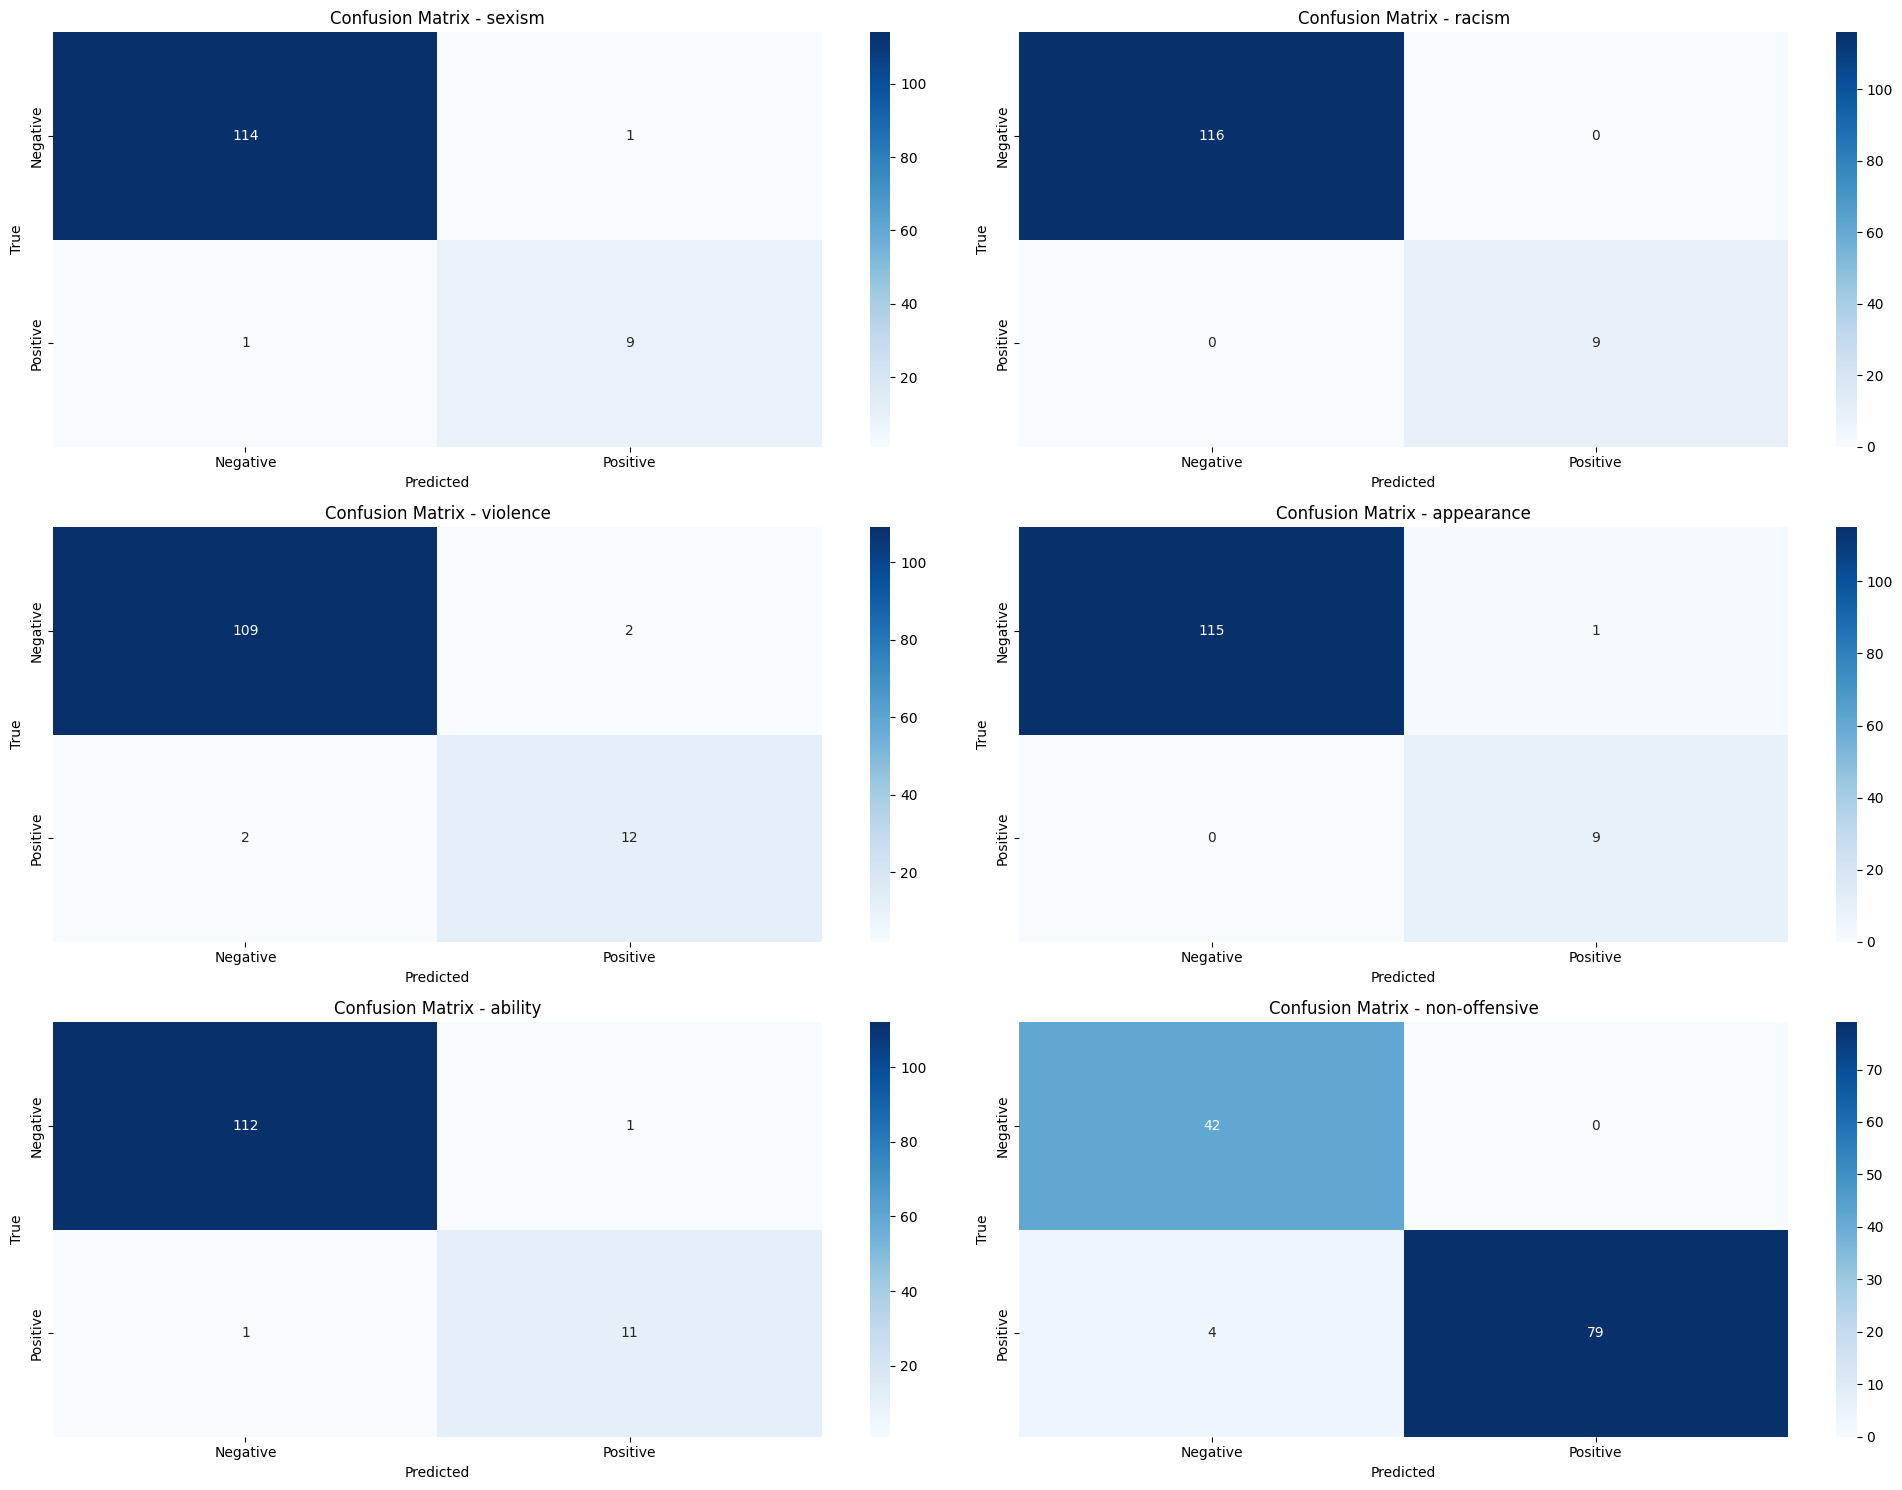

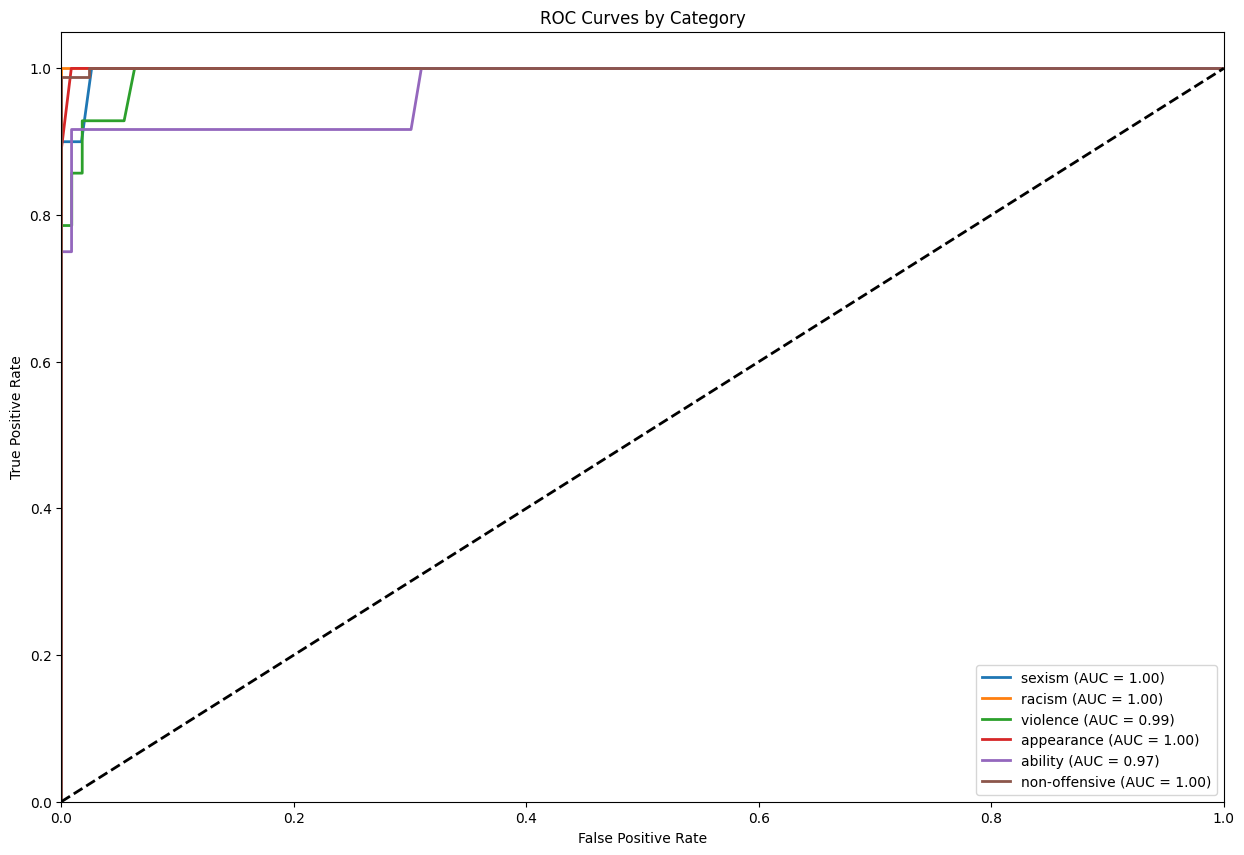

In [21]:
import pandas as pd
import numpy as np
import torch
import random
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torch import nn

# Function to generate synthetic examples using examples from the dataset
def generate_synthetic_examples(df, category, num_examples=10, domain="female soccer"):
    """
    Generate synthetic examples for a specific category based on existing examples.
    
    Args:
        df: DataFrame with the original data
        category: Category to generate examples for
        num_examples: Number of examples to generate
        domain: Domain to focus on (e.g., "female soccer")
        
    Returns:
        List of synthetic examples
    """
    # Get existing examples for this category to use as seeds
    existing_examples = df[df[category] == 1]['comment'].tolist()
    
    # If no existing examples or very few, use some generic patterns
    if len(existing_examples) < 3:
        if category == 'sexism':
            patterns = [
                f"Women's {domain} is not real {domain}, they should stick to [activity].",
                f"Female {domain} players are only popular because of their looks, not skill.",
                f"Women are too [negative trait] to play {domain} at a high level.",
                f"The problem with women's {domain} is that women are naturally worse at sports.",
                f"No one watches women's {domain} because they're not as good as men.",
                f"This female {domain} player only got attention because she's pretty.",
                f"Women's {domain} is boring because they're slower and weaker.",
                f"They should reduce the {domain} field size for women since they can't cover as much ground.",
                f"Women {domain} players earn less because they generate less revenue, it's simple economics.",
                f"The women's {domain} team is just asking for special treatment."
            ]
        elif category == 'racism':
            patterns = [
                f"Players from [nationality/ethnicity] aren't technically skilled enough for {domain}.",
                f"That [ethnicity] player only got on the team because of diversity quotas.",
                f"{domain} was better before they let so many [ethnicity] players in.",
                f"Teams from [region/country] always play dirty because it's in their culture.",
                f"You can tell that player is [ethnicity] by how [negative stereotype] they play.",
                f"[Nationality] players always dive more in {domain}, it's part of their culture.",
                f"{domain} fans from [country] are naturally more violent, it's genetic.",
                f"The [ethnicity] players on that {domain} team all look the same.",
                f"[Country] doesn't produce good {domain} players because they're not built for it.",
                f"That referee is clearly biased against [ethnicity] players."
            ]
        elif category == 'violence':
            patterns = [
                f"That referee deserves to be beaten for that call in the {domain} match.",
                f"Someone should attack that {domain} player for missing that shot.",
                f"I'd like to hurt the coach for making that substitution in the {domain} game.",
                f"Fans should physically confront that {domain} player after the match.",
                f"That {domain} team should be assaulted for such a poor performance.",
                f"I hope someone breaks that player's legs in the next {domain} match.",
                f"The only solution is to punch that {domain} commentator in the face.",
                f"I would smash my TV if I had to watch another women's {domain} match.",
                f"That {domain} player deserves to get hit hard in the next game.",
                f"Fans should throw objects at that {domain} team for playing so badly."
            ]
        elif category == 'appearance':
            patterns = [
                f"That female {domain} player is too ugly to be on camera.",
                f"She should focus more on losing weight than playing {domain}.",
                f"No wonder she's bad at {domain}, look at how fat she is.",
                f"That {domain} player would be more popular if she was prettier.",
                f"Who cares about her {domain} skills when she looks like that?",
                f"Her thighs are too big for a {domain} player, it's distracting.",
                f"That female {domain} player's hairstyle is ridiculous, focus on the game.",
                f"She's too skinny to be taken seriously as a {domain} player.",
                f"The uniforms make these female {domain} players look so unflattering.",
                f"I can't focus on her {domain} skills because her face is so distracting."
            ]
        elif category == 'ability':
            patterns = [
                f"You must be mentally disabled if you think women's {domain} is worth watching.",
                f"Only someone with brain damage would coach women's {domain}.",
                f"That {domain} player looks like she has some kind of disability.",
                f"Are you blind? That's why you support women's {domain}.",
                f"You must have a learning disability to not understand why men's {domain} is superior.",
                f"What are you, retarded? This {domain} team is clearly better.",
                f"That player moves like she's got a physical disability on the {domain} field.",
                f"You'd need to be deaf to not hear how the crowd hates this {domain} team.",
                f"The coach must be mentally challenged to make such poor {domain} decisions.",
                f"Only people with cognitive issues would find women's {domain} entertaining."
            ]
        else:  # non-offensive
            patterns = [
                f"I really enjoyed watching the women's {domain} match yesterday.",
                f"The technical skill in women's {domain} has improved so much.",
                f"That was an amazing goal in the {domain} championship.",
                f"The tactical approach of this women's {domain} team is impressive.",
                f"Female {domain} players are showing great progress in recent years.",
                f"The women's {domain} world cup was really exciting to watch.",
                f"I admire the dedication of these {domain} players.",
                f"The defensive strategy in this women's {domain} match is fascinating.",
                f"Both teams played exceptionally well in this {domain} match.",
                f"The level of athleticism in women's {domain} keeps getting better every year."
            ]
    else:
        # Use existing examples as patterns
        patterns = existing_examples
    
    # Generate variations based on patterns
    synthetic_examples = []
    
    for _ in range(num_examples):
        # Choose a random pattern to base this example on
        base_pattern = random.choice(patterns)
        
        # Create variations based on the domain and category
        if category == 'sexism':
            replacements = {
                '[activity]': random.choice(['cooking', 'cleaning', 'modeling', 'cheerleading', 'dancing', 'fashion']),
                '[negative trait]': random.choice(['emotional', 'weak', 'fragile', 'sensitive', 'indecisive', 'dramatic'])
            }
        elif category == 'racism':
            replacements = {
                '[nationality/ethnicity]': random.choice(['African', 'Asian', 'Latin American', 'Eastern European', 'Middle Eastern']),
                '[ethnicity]': random.choice(['Black', 'Asian', 'Latino', 'African', 'Arab']),
                '[region/country]': random.choice(['African countries', 'South American teams', 'Eastern European nations', 'Asian teams']),
                '[negative stereotype]': random.choice(['aggressively', 'sloppily', 'lazily', 'dishonestly', 'chaotically'])
            }
        elif category == 'appearance':
            # No specific replacements needed
            replacements = {}
        elif category == 'ability':
            # No specific replacements needed
            replacements = {}
        elif category == 'violence':
            # No specific replacements needed
            replacements = {}
        else:  # non-offensive
            replacements = {}
        
        # Apply replacements
        new_example = base_pattern
        for key, value in replacements.items():
            if key in new_example:
                new_example = new_example.replace(key, value)
        
        # Add some noise/variation
        if random.random() < 0.3:
            new_example = new_example.replace(".", "!")
        
        if random.random() < 0.4:
            intensifiers = ["so", "really", "extremely", "very", "absolutely", "totally"]
            words = new_example.split()
            for i in range(len(words) - 1):
                if random.random() < 0.1:
                    words.insert(i+1, random.choice(intensifiers))
            new_example = " ".join(words)
        
        # Add to our collection if it's not a duplicate
        if new_example not in synthetic_examples:
            synthetic_examples.append(new_example)
    
    return synthetic_examples

# Function to enhance dataset with synthetic examples
def enhance_dataset_with_synthetic_examples(df, categories, examples_per_category=200, domain="female soccer", skip_categories=None):
    """
    Enhance the dataset with synthetically generated examples.
    
    Args:
        df: Original DataFrame
        categories: List of categories to generate examples for
        examples_per_category: Number of examples to generate per category
        domain: Domain to focus on
        skip_categories: List of categories to skip enhancement for
    
    Returns:
        Enhanced DataFrame
    """
    # Default to empty list if None
    if skip_categories is None:
        skip_categories = []
    
    # Create a copy to avoid modifying the original
    enhanced_df = df.copy()
    
    # Generate synthetic examples for each underrepresented category
    for category in categories:
        # Skip categories in the skip list
        if category in skip_categories:
            print(f"Skipping enhancement for {category} as requested")
            continue
        
        # Calculate current count
        current_count = df[category].sum()
        print(f"Original {category} examples: {current_count}")
        
        # Generate synthetic examples
        synthetic_examples = generate_synthetic_examples(
            df, 
            category, 
            num_examples=examples_per_category,
            domain=domain
        )
        
        # Create new rows for the DataFrame
        new_rows = []
        for example in synthetic_examples:
            # Initialize with all categories set to 0
            new_row = {cat: 0 for cat in categories}
            # Set this category to 1
            new_row[category] = 1
            # Add the comment text
            new_row['comment'] = example
            # Set as labeled
            if 'is_labeled' in df.columns:
                new_row['is_labeled'] = True
                
            new_rows.append(new_row)
        
        # Convert to DataFrame
        synthetic_df = pd.DataFrame(new_rows)
        
        # Append to the enhanced DataFrame
        enhanced_df = pd.concat([enhanced_df, synthetic_df], ignore_index=True)
        
        # Calculate new count
        new_count = enhanced_df[category].sum()
        print(f"After enhancement, {category} examples: {new_count} (+{new_count-current_count})")
    
    return enhanced_df

# Function to convert pandas DataFrame to HuggingFace Dataset
def convert_to_hf_dataset(df, tokenizer, categories, max_length=128):
    """Convert pandas DataFrame to HuggingFace Dataset."""
    # Extract features and labels
    comments = df['comment'].tolist()
    labels = df[categories].values.astype(np.float32)
    
    # Tokenize the comments
    encodings = tokenizer(
        comments,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='np'
    )
    
    # Create a dataset dictionary
    dataset_dict = {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    }
    
    # Convert to HF Dataset
    dataset = HFDataset.from_dict(dataset_dict)
    return dataset

# MODIFIED: Enhanced compute_metrics with lower thresholds for minority classes
def compute_metrics(eval_pred):
    """Compute metrics for multi-label classification with focus on macro F1."""
    predictions, labels = eval_pred
    # Apply sigmoid to get probabilities
    sigmoid_preds = 1 / (1 + np.exp(-predictions))
    
    # Use different thresholds for different classes to improve minority class detection
    y_pred = np.zeros_like(sigmoid_preds, dtype=int)
    
    # Use a higher threshold for majority class
    y_pred[:, -1] = (sigmoid_preds[:, -1] >= 0.7).astype(int)  # non-offensive uses 0.7 (stricter)
    
    # Use MUCH lower thresholds for minority classes to increase recall
    for i in range(len(y_pred[0])-1):  # All except the last column (non-offensive)
        y_pred[:, i] = (sigmoid_preds[:, i] >= 0.2).astype(int)  # Use 0.2 for minority classes
    
    # Calculate metrics
    metrics = {}
    metrics['micro_f1'] = f1_score(labels, y_pred, average='micro')
    metrics['macro_f1'] = f1_score(labels, y_pred, average='macro')
    
    # Per-category metrics
    categories = ["sexism", "racism", "violence", "appearance", "ability", "non-offensive"]
    for i, category in enumerate(categories):
        if np.sum(labels[:, i]) > 0:  # Only if at least one positive example exists
            metrics[f'{category}_f1'] = f1_score(labels[:, i], y_pred[:, i], average='binary')
            metrics[f'{category}_precision'] = precision_score(labels[:, i], y_pred[:, i], average='binary', zero_division=0)
            metrics[f'{category}_recall'] = recall_score(labels[:, i], y_pred[:, i], average='binary', zero_division=0)
    
    return metrics

# Prediction function with proper tensor handling
def get_predictions(dataset, model, device, batch_size=16, threshold=0.5, category_thresholds=None):
    """
    Generate predictions for the dataset.
    
    Args:
        dataset: HuggingFace dataset
        model: Trained model
        device: Device to use
        batch_size: Batch size
        threshold: Default threshold for classification
        category_thresholds: Dictionary mapping category indices to thresholds
    """
    if category_thresholds is None:
        # Use the same thresholds as in compute_metrics
        category_thresholds = {
            0: 0.2,  # sexism
            1: 0.2,  # racism
            2: 0.2,  # violence
            3: 0.2,  # appearance
            4: 0.2,  # ability
            5: 0.7   # non-offensive
        }
    
    model.eval()
    all_preds = []
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        collate_fn=lambda batch: {
            'input_ids': torch.tensor([item['input_ids'] for item in batch]),
            'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
            'labels': torch.tensor([item['labels'] for item in batch])
        }
    )
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        all_preds.append(probs)
    
    # Return probabilities
    return np.vstack(all_preds)

# NEW function: Create CustomTrainer with weighted loss
class WeightedBCEWithLogitsLoss(nn.Module):
    """
    Binary Cross Entropy with logits loss that applies class weights.
    Useful for handling class imbalance.
    """
    def __init__(self, pos_weights, reduction='mean'):
        super().__init__()
        self.pos_weights = pos_weights
        self.reduction = reduction

    def forward(self, logits, targets):
        # Apply sigmoid for numerical stability
        probs = torch.sigmoid(logits)
        # Calculate loss with pos_weight for each class
        loss = torch.zeros_like(logits)
        
        # Apply weight for each class
        for i in range(logits.size(1)):
            # Extract this class
            class_logits = logits[:, i]
            class_targets = targets[:, i]
            
            # Apply BCEWithLogitsLoss for this class with its weight
            loss[:, i] = nn.functional.binary_cross_entropy_with_logits(
                class_logits, 
                class_targets, 
                pos_weight=torch.tensor([self.pos_weights[i]]).to(logits.device),
                reduction='none'
            )
        
        # Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

class CustomTrainer(Trainer):
    """Custom trainer with weighted loss to handle class imbalance."""
    def __init__(self, pos_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights or [1.0] * self.model.config.num_labels
        
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply weighted loss
        loss_fct = WeightedBCEWithLogitsLoss(pos_weights=self.pos_weights)
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

# Function to ensure category examples in test set
def ensure_category_examples_in_test(df, test_df, categories, min_examples=5, domain="female soccer"):
    """
    Ensures that test set has at least min_examples of each category.
    
    Args:
        df: Original full DataFrame
        test_df: Test DataFrame that might be missing category examples
        categories: List of categories to check
        min_examples: Minimum number of examples per category
        domain: Domain for synthetic examples
        
    Returns:
        Updated test DataFrame with examples for each category
    """
    # Create a copy of the test DataFrame
    enhanced_test_df = test_df.copy()
    
    # Check each category
    for category in categories:
        # Get current count in test set
        current_count = test_df[category].sum()
        print(f"Test set {category} examples: {current_count}")
        
        # If we don't have enough examples, add synthetic ones
        if current_count < min_examples:
            needed = min_examples - current_count
            print(f"Need {needed} more {category} examples in test set")
            
            # Generate synthetic examples
            synthetic_examples = generate_synthetic_examples(
                df,  # Use the full dataset as source
                category,
                num_examples=needed,
                domain=domain
            )
            
            # Create new rows for the DataFrame
            new_rows = []
            for example in synthetic_examples:
                # Initialize with all categories set to 0
                new_row = {cat: 0 for cat in categories}
                # Set this category to 1
                new_row[category] = 1
                # Add the comment text
                new_row['comment'] = example
                # Set as labeled
                if 'is_labeled' in df.columns:
                    new_row['is_labeled'] = True
                    
                new_rows.append(new_row)
            
            # Convert to DataFrame
            synthetic_df = pd.DataFrame(new_rows)
            
            # Append to the enhanced test DataFrame
            enhanced_test_df = pd.concat([enhanced_test_df, synthetic_df], ignore_index=True)
            
            # Print the new count
            new_count = enhanced_test_df[category].sum()
            print(f"After enhancement, test set {category} examples: {new_count}")
    
    return enhanced_test_df

# MODIFIED: Custom stratified split with more test examples
def stratified_multi_label_split(df, categories, test_size=0.2, min_test_examples=10, random_state=42):
    """
    Custom stratified split for multi-label data ensuring minimum examples per category.
    
    Args:
        df: DataFrame to split
        categories: List of category columns
        test_size: Fraction of data to use for test
        min_test_examples: Minimum number of examples per category in test set
        random_state: Random seed
        
    Returns:
        train_df, test_df: Split DataFrames
    """
    # Initialize empty test set
    test_indices = set()
    train_indices = set(range(len(df)))
    
    # For each category, ensure we have min_test_examples
    for category in categories:
        # Get indices where this category is 1
        category_indices = df[df[category] == 1].index.tolist()
        
        # If we have enough examples
        if len(category_indices) >= min_test_examples:
            # Shuffle the indices
            random.Random(random_state).shuffle(category_indices)
            # Take the first min_test_examples
            examples_to_add = set(category_indices[:min_test_examples])
            # Add to test indices
            test_indices.update(examples_to_add)
        else:
            # If not enough examples, take what we have
            test_indices.update(category_indices)
            print(f"Warning: Only {len(category_indices)} examples of {category} available")
    
    # Calculate how many more test examples we need for the desired test_size
    desired_test_size = int(len(df) * test_size)
    additional_needed = max(0, desired_test_size - len(test_indices))
    
    if additional_needed > 0:
        # Get remaining indices not yet in test set
        remaining_indices = list(train_indices - test_indices)
        # Shuffle them
        random.Random(random_state).shuffle(remaining_indices)
        # Take what we need
        additional_indices = set(remaining_indices[:additional_needed])
        # Add to test indices
        test_indices.update(additional_indices)
    
    # Create the train indices by removing test indices from all indices
    train_indices = set(range(len(df))) - test_indices
    
    # Convert to list for indexing
    train_indices = list(train_indices)
    test_indices = list(test_indices)
    
    # Create DataFrames
    train_df = df.iloc[train_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)
    
    return train_df, test_df

# NEW FUNCTION: Create balanced batches during training
def create_balanced_sampler(dataset, categories):
    """
    Creates a sampler that ensures each batch has examples from all categories.
    Helps prevent the model from getting stuck in local minima.
    
    Args:
        dataset: Dataset to sample from
        categories: Category names
    
    Returns:
        Sampler for DataLoader
    """
    pass  # Not implemented here as we're using HuggingFace Trainer API

# IMPROVED: Main function with better balancing for macro F1
def train_model_with_synthetic_data(data_path, domain="female soccer"):
    """
    Complete pipeline to train model with synthetic data enhancement,
    optimized for maximizing macro F1 score.
    
    Args:
        data_path: Path to the original labeled data
        domain: Domain to focus synthetic examples on
    """
    # Configuration
    CONFIG = {
        "test_size": 0.2,
        "model_name": "distilbert-base-uncased",
        "output_dir": "./finetuned_model",
        "max_length": 128,
        "batch_size": 16,
        "learning_rate": 2e-5,  # Slightly lower learning rate for better generalization
        "epochs": 15,  # More epochs to ensure convergence
        "seed": 42,
        "categories": ["sexism", "racism", "violence", "appearance", "ability", "non-offensive"],
        "min_test_examples": 10,  # Increased minimum examples per category in test set
        # Thresholds for evaluation
        "thresholds": {
            "sexism": 0.2,
            "racism": 0.2,
            "violence": 0.2,
            "appearance": 0.2,
            "ability": 0.2,
            "non-offensive": 0.7
        },
        # Class weights to combat imbalance (higher values for minority classes)
        "class_weights": [10.0, 10.0, 8.0, 10.0, 8.0, 1.0]  # Higher weights for minority classes
    }
    
    # Set seeds
    torch.manual_seed(CONFIG["seed"])
    np.random.seed(CONFIG["seed"])
    random.seed(CONFIG["seed"])
    
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    print(f"Loading data from {data_path}")
    df = pd.read_csv(data_path)
    
    # Filter labeled data
    if 'is_labeled' in df.columns:
        df = df[df['is_labeled'] == True].reset_index(drop=True)
        print(f"Found {len(df)} labeled comments")
    
    # Use custom stratified split with more examples per category
    train_df, test_df = stratified_multi_label_split(
        df, 
        CONFIG["categories"], 
        test_size=CONFIG["test_size"],
        min_test_examples=CONFIG["min_test_examples"],
        random_state=CONFIG["seed"]
    )
    
    # Ensure test set has examples from each category
    test_df = ensure_category_examples_in_test(
        df,
        test_df,
        CONFIG["categories"],
        min_examples=CONFIG["min_test_examples"],
        domain=domain
    )
    
    # MODIFIED: Stronger enhancement of minority classes
    # Generate more examples for rare categories
    examples_per_category = {
        "sexism": 800,       # More examples for rarer classes
        "racism": 800,
        "violence": 600,
        "appearance": 800,
        "ability": 600,
        "non-offensive": 0   # None for majority class
    }
    
    # Enhanced training data with more synthetic examples for minority classes
    enhanced_train_df = train_df.copy()
    
    # Enhance each category separately with its optimal count
    for category, num_examples in examples_per_category.items():
        if num_examples > 0:
            current_count = enhanced_train_df[category].sum()
            print(f"Enhancing {category} examples from {current_count}...")
            
            # Generate synthetic examples
            synthetic_examples = generate_synthetic_examples(
                df,  # Use full dataset as source
                category,
                num_examples=num_examples,
                domain=domain
            )
            
            # Create new rows
            new_rows = []
            for example in synthetic_examples:
                # Initialize with all categories set to 0
                new_row = {cat: 0 for cat in CONFIG["categories"]}
                # Set this category to 1
                new_row[category] = 1
                # Add the comment text
                new_row['comment'] = example
                # Set as labeled
                if 'is_labeled' in df.columns:
                    new_row['is_labeled'] = True
                    
                new_rows.append(new_row)
            
            # Convert to DataFrame
            synthetic_df = pd.DataFrame(new_rows)
            
            # Append to the enhanced train DataFrame
            enhanced_train_df = pd.concat([enhanced_train_df, synthetic_df], ignore_index=True)
            
            # Print the new count
            new_count = enhanced_train_df[category].sum()
            print(f"After enhancement, {category} examples: {new_count} (+{new_count-current_count})")
    
    # Downsample non-offensive in training set to reduce imbalance
    non_offensive_count = enhanced_train_df["non-offensive"].sum()
    non_offensive_indices = enhanced_train_df[enhanced_train_df["non-offensive"] == 1].index.tolist()
    
    # Target a more balanced ratio
    target_non_offensive = int(enhanced_train_df.shape[0] * 0.4)  # Aim for 40% non-offensive
    if non_offensive_count > target_non_offensive:
        # Shuffle indices
        random.shuffle(non_offensive_indices)
        # Select indices to remove
        indices_to_remove = non_offensive_indices[:int(non_offensive_count - target_non_offensive)]
        # Drop rows
        enhanced_train_df = enhanced_train_df.drop(indices_to_remove).reset_index(drop=True)
        print(f"Downsampled non-offensive examples from {non_offensive_count} to {enhanced_train_df['non-offensive'].sum()}")
    
    # Print dataset statistics
    print(f"\nOriginal training set size: {len(train_df)}")
    print(f"Enhanced training set size: {len(enhanced_train_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Calculate and print class distribution in enhanced dataset
    print("\nClass distribution in enhanced training set:")
    for category in CONFIG["categories"]:
        count = enhanced_train_df[category].sum()
        print(f"{category}: {count} ({count/len(enhanced_train_df):.2%})")
    
    # Print class distribution in test set
    print("\nClass distribution in test set:")
    for category in CONFIG["categories"]:
        count = test_df[category].sum()
        print(f"{category}: {count} ({count/len(test_df):.2%})")
    
    # Load model and tokenizer
    print(f"\nLoading model: {CONFIG['model_name']}")
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
    model = AutoModelForSequenceClassification.from_pretrained(
        CONFIG["model_name"],
        num_labels=len(CONFIG["categories"]),
        problem_type="multi_label_classification"
    )
    model.to(device)
    
    # Convert to datasets
    train_dataset = convert_to_hf_dataset(enhanced_train_df, tokenizer, CONFIG["categories"], CONFIG["max_length"])
    test_dataset = convert_to_hf_dataset(test_df, tokenizer, CONFIG["categories"], CONFIG["max_length"])
    
    # Training arguments compatible with older versions of transformers
    training_args = TrainingArguments(
        output_dir=CONFIG["output_dir"],
        num_train_epochs=CONFIG["epochs"],
        per_device_train_batch_size=CONFIG["batch_size"],
        per_device_eval_batch_size=CONFIG["batch_size"],
        learning_rate=CONFIG["learning_rate"],
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        save_steps=100,
        # Older versions compatibility - removing newer parameters
        gradient_accumulation_steps=4,    # Helps with small batch sizes
        # Removing evaluation_strategy, save_strategy, warmup_ratio, etc.
        # which may not be available in older versions
    )
    
    # Create custom loss function with weights
    # Convert class weights to tensor
    pos_weights = torch.tensor(CONFIG["class_weights"]).to(device)
    
    # Check if CustomTrainer is working with your version
    try:
        trainer = CustomTrainer(
            pos_weights=pos_weights,
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics
        )
    except Exception as e:
        print(f"CustomTrainer failed with error: {e}")
        print("Falling back to standard Trainer with compute_metrics")
        
        # Fall back to standard trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics
        )
    
    # Train
    print("Starting training...")
    trainer.train()
    
    # Evaluate
    results = trainer.evaluate()
    
    print("\nEvaluation results:")
    for key, value in results.items():
        if isinstance(value, (int, float)):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")
    
    # Save
    model.save_pretrained(CONFIG["output_dir"])
    tokenizer.save_pretrained(CONFIG["output_dir"])
    
    # Generate predictions with custom thresholds
    category_thresholds = {
        0: 0.2,  # sexism - lower threshold to catch more examples
        1: 0.2,  # racism
        2: 0.2,  # violence
        3: 0.2,  # appearance
        4: 0.2,  # ability
        5: 0.7   # non-offensive - higher threshold to be more selective
    }
    
    test_probs = get_predictions(
        test_dataset, 
        model, 
        device, 
        CONFIG["batch_size"],
        category_thresholds=category_thresholds
    )
    
    # Apply different thresholds for different categories
    test_preds = np.zeros_like(test_probs, dtype=int)
    for i, threshold in category_thresholds.items():
        test_preds[:, i] = (test_probs[:, i] >= threshold).astype(int)
    
    # Create predictions DataFrame
    test_pred_df = test_df.copy()
    for i, category in enumerate(CONFIG["categories"]):
        test_pred_df[f"{category}_prob"] = test_probs[:, i]
        test_pred_df[f"{category}_pred"] = test_preds[:, i]
    
    # Save predictions
    test_pred_df.to_csv('test_predictions.csv', index=False)
    
    # Calculate and print detailed test metrics
    print("\nDetailed test metrics with optimized thresholds:")
    category_metrics = {}
    for i, category in enumerate(CONFIG["categories"]):
        # Skip if no positive examples
        if np.sum(test_df[category]) == 0:
            print(f"{category}: No positive examples in test set")
            continue
            
        # Calculate metrics
        prec = precision_score(test_df[category], test_preds[:, i], zero_division=0)
        rec = recall_score(test_df[category], test_preds[:, i], zero_division=0)
        f1 = f1_score(test_df[category], test_preds[:, i], zero_division=0)
        
        category_metrics[category] = {"precision": prec, "recall": rec, "f1": f1}
        print(f"{category}:")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall: {rec:.4f}")
        print(f"  F1 Score: {f1:.4f}")
    
    # Calculate macro F1 manually
    f1_scores = [metrics["f1"] for metrics in category_metrics.values()]
    macro_f1 = sum(f1_scores) / len(f1_scores)
    print(f"\nManual macro F1: {macro_f1:.4f}")
    
    # Plot confusion matrices
    plt.figure(figsize=(20, 15))
    for i, category in enumerate(CONFIG["categories"]):
        plt.subplot(3, 2, i+1)
        
        # Ensure we have both classes represented in the labels parameter
        cm = confusion_matrix(test_df[category], test_preds[:, i], labels=[0, 1])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix - {category}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    
    # Plot ROC curves for each category if sklearn.metrics has roc_curve
    try:
        from sklearn.metrics import roc_curve, auc
        
        plt.figure(figsize=(15, 10))
        for i, category in enumerate(CONFIG["categories"]):
            # Skip if no positive examples
            if np.sum(test_df[category]) == 0:
                continue
                
            # Calculate ROC curve
            try:
                fpr, tpr, _ = roc_curve(test_df[category], test_probs[:, i])
                auc_score = auc(fpr, tpr)
                
                plt.plot(fpr, tpr, lw=2, label=f'{category} (AUC = {auc_score:.2f})')
            except Exception as e:
                print(f"Could not calculate ROC curve for {category}: {e}")
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves by Category')
        plt.legend(loc="lower right")
        plt.savefig('roc_curves.png')
    except ImportError:
        print("roc_curve not available in sklearn.metrics, skipping ROC curve plotting")
    
    print("Training complete! Saved model and predictions.")
    return model, tokenizer

# Example usage
if __name__ == "__main__":
    train_model_with_synthetic_data("labeled_data.csv", domain="female soccer")